<a href="https://colab.research.google.com/github/darthwaydr007/gan/blob/master/MNIST_imbalanced_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd
import random
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU')
    device = torch.device("cpu")
    

There are 1 GPU available.
GPU: Tesla K80


In [ ]:
mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
#train_labels = mnist_train.iloc[:,0]
#mnist_train.drop(mnist_train.columns[0], axis=1, inplace=True)
mnist_train

,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19995,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19996,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19997,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_mnist = pd.read_csv('/content/sample_data/mnist_test.csv')

In [ ]:

mnist_train.rename(columns={'6':'label'}, 
                 inplace=True)
train_labels = mnist_train[['label']]
classes = train_labels['label'].unique()
classes

array([5, 7, 9, 2, 0, 6, 8, 3, 4, 1])

In [ ]:
traindf_one = mnist_train[mnist_train['label'] == 1]
traindf_one[:500]

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.551,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4432,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4435,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4438,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
imbalanced_mnist = pd.DataFrame()
for i in classes:
  temp = mnist_train[mnist_train['label'] == i]
  if i%2 == 0:
    temp = temp[:750]
  else:
    temp = temp[:1500]
  imbalanced_mnist = pd.concat([imbalanced_mnist , temp])


In [ ]:
balanced_mnist = pd.DataFrame()
for i in classes:
  temp = mnist_train[mnist_train['label'] == i]
  temp = temp[:1500]
  balanced_mnist = pd.concat([balanced_mnist , temp])

In [ ]:
def split_dataset(imbalanced_mnist):
  imbalanced_mnist = imbalanced_mnist.sample(frac=1).reset_index(drop=True)
  labels = imbalanced_mnist.iloc[:,0]
  imbalanced_mnist.drop(imbalanced_mnist.columns[0], axis=1, inplace=True)
  return imbalanced_mnist.values , labels.values

In [ ]:
a , b = split_dataset(balanced_mnist)

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self , dataset):
    self.data = dataset
    self.dataset ,  self.labels = split_dataset(self.data)
    self.dataset = self.dataset
    self.labels = self.labels 
    self.length = len(self.labels)

  def __len__(self):
    return self.length

  def __getitem__(self , index):
    return {
        'img' : self.dataset[index] ,
        'label' : self.labels[index] 
    }

In [ ]:
BATCH_SIZE = 48
imbalanced = MNISTDataset(imbalanced_mnist)
balances = MNISTDataset(balanced_mnist)
test  = MNISTDataset(test_mnist)
train_loader_imbalanced = torch.utils.data.DataLoader(imbalanced , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)
train_loader_balanced = torch.utils.data.DataLoader(balances , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)
test_loader = torch.utils.data.DataLoader(test , batch_size = BATCH_SIZE, shuffle = True , drop_last=True)

In [ ]:
train_loader_balanced

tensor(7)


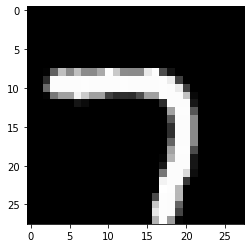

In [ ]:
for batch , (data) in enumerate(train_loader_imbalanced):
  x = data['img'][0]
  print(data['label'][0])
  x= x.numpy()
  plt.imshow(x.reshape(28, 28), cmap="gray")
  break

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
            
        )
  
  def forward(self, x):
        x = self.model(x.view(x.size(0),784))
        return F.log_softmax(x).cuda()


In [ ]:
net1 = Net().cuda()
#criterion = F.nll_loss() 
lr = 0.0002
EPOCHS = 10
optimizer1 = optim.Adam(net1.parameters() , lr = lr)

In [ ]:
net2 = Net().cuda()
optimizer2 = optim.Adam(net2.parameters() , lr = lr)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

In [ ]:
for i in range(0,10):
  net1.train()
  total_loss = 0
  print('======== Epoch {:} / {:} ========'.format(i + 1, EPOCHS))
  for batch , (img1 , label) in enumerate(train_loader_imbalanced):
    
    img1 = data['img'].cuda()
    label = data['label'].cuda()
    
    optimizer1.zero_grad()
    output = net1(img1.float())
    
    loss = F.nll_loss(output , label)
    loss.backward()
    optimizer1.step()
    
    total_loss = total_loss + loss.mean().item()
    if batch % 100 == 0 and not batch == 0:
          print('AvgLoss : {:} , Batch Loss : {:}'.format(total_loss/batch , loss.mean().item()))

======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


AvgLoss : 0.19137751383997967 , Batch Loss : 0.0155174033716321
AvgLoss : 0.09670693160536757 , Batch Loss : 0.0003368854522705078
======== Epoch 2 / 10 ========
AvgLoss : 0.0008858046437671874 , Batch Loss : 0.0002493858337402344
AvgLoss : 0.0006427647907912615 , Batch Loss : 3.864367681671865e-05
======== Epoch 3 / 10 ========
AvgLoss : 0.00013610293550755158 , Batch Loss : 0.0004608035087585449
AvgLoss : 0.00014081264553851723 , Batch Loss : 3.8683414459228516e-05
======== Epoch 4 / 10 ========
AvgLoss : 0.0001261255128247285 , Batch Loss : 3.331899642944336e-05
AvgLoss : 0.00011342803538923363 , Batch Loss : 3.522634506225586e-05
======== Epoch 5 / 10 ========
AvgLoss : 6.388584837736744e-05 , Batch Loss : 2.0901361494907178e-05
AvgLoss : 4.480093745968361e-05 , Batch Loss : 5.046526439400623e-06
======== Epoch 6 / 10 ========
AvgLoss : 8.874058682977193e-05 , Batch Loss : 8.442004764219746e-05
AvgLoss : 6.166174996593554e-05 , Batch Loss : 4.331270702095935e-06
======== Epoch 7 / 

In [ ]:
for i in range(0,EPOCHS):
  net2.train()
  total_loss = 0
  print('======== Epoch {:} / {:} ========'.format(i + 1, EPOCHS))
  for batch , (data) in enumerate(train_loader_imbalanced):
    
    img1 = data['img'].cuda()
    label = data['label'].cuda()
    
    
    optimizer2.zero_grad()
    output = net2(img1.float())

    loss = F.nll_loss(output , label)
    loss.backward()
    optimizer2.step()
    
    total_loss = total_loss + loss.mean().item()
    if batch % 100 == 0 and not batch == 0:
          print('AvgLoss : {:} , Batch Loss : {:}'.format(total_loss/batch , loss.mean().item()))

======== Epoch 1 / 10 ========


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


AvgLoss : 0.8747060367465019 , Batch Loss : 0.7429822087287903
AvgLoss : 0.64502277597785 , Batch Loss : 0.3586443364620209
======== Epoch 2 / 10 ========
AvgLoss : 0.28468433022499084 , Batch Loss : 0.2288234978914261
AvgLoss : 0.28529777128249406 , Batch Loss : 0.28080737590789795
======== Epoch 3 / 10 ========
AvgLoss : 0.2090129666402936 , Batch Loss : 0.05529285967350006
AvgLoss : 0.20410015646368265 , Batch Loss : 0.1833747774362564
======== Epoch 4 / 10 ========
AvgLoss : 0.15846468713134526 , Batch Loss : 0.33468469977378845
AvgLoss : 0.16981590986251832 , Batch Loss : 0.20034907758235931
======== Epoch 5 / 10 ========
AvgLoss : 0.1400865636859089 , Batch Loss : 0.07963147759437561
AvgLoss : 0.13348511825781315 , Batch Loss : 0.14627857506275177
======== Epoch 6 / 10 ========
AvgLoss : 0.11077964041382074 , Batch Loss : 0.16154895722866058
AvgLoss : 0.1278176011145115 , Batch Loss : 0.09563827514648438
======== Epoch 7 / 10 ========
AvgLoss : 0.11177087594754993 , Batch Loss : 

In [ ]:
correct = 0
total = 0
net1.eval()
with torch.no_grad():
  for batch_idx, (data) in enumerate(test_loader):

    img1 = data['img'].cuda()
    img1 = transform(img1.float().cpu().detach().numpy())
    img1 = img1.view(BATCH_SIZE,784).cuda()
    #img1.requires_grad = True
    label = data['label'].cuda()
    
    output = net1(img1.float())

    for idx ,i in enumerate(output):
      #print(torch.argmax(i))
      if torch.argmax(i) == label[idx]:
        correct += 1
      total += 1
print("accuracy: " , round(correct/total , 3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy:  0.673


In [ ]:
correct = 0
total = 0
net2.eval()
with torch.no_grad():
  for batch_idx, (data) in enumerate(test_loader):

    img1 = data['img'].cuda()
    img1 = transform(img1.float().cpu().detach().numpy())
    img1 = img1.view(BATCH_SIZE,784).cuda()
    #img1.requires_grad = True
    label = data['label'].cuda()
    
    output = net2(img1.float())

    for idx ,i in enumerate(output):
      #print(torch.argmax(i))
      if torch.argmax(i) == label[idx]:
        correct += 1
      total += 1
print("accuracy: " , round(correct/total , 3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy:  0.953
